In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [4]:
# metadata - check file names 
micro_meta = pd.read_csv('/project/bf528/project_3/toxgroups/toxgroup_6_mic_info.csv')
rna_meta = pd.read_csv('/project/bf528/project_3/toxgroups/toxgroup_6_rna_info.csv')

# normalized counts
limma_all = pd.read_csv('/projectnb/bf528/project_3/samples/liver-normalization-rma.txt', delimiter = "\t", usecols=[0], names=['ProbeID'], header=0)

# DESeq2 all detected genes 
deseq_all = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/ryan_tmp/result/deseq/res_AhR_shrink.csv', header=0, usecols=[0], names=['RefseqID'])

# DESeq2 DE results 
deseq_MCT = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/ryan_tmp/result/deseq/deg_AhR.csv', header=0,usecols=[0,1,2], names=["RefseqID", "baseMean", "FC"])
deseq_FCZ = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/ryan_tmp/result/deseq/deg_CAR_PXR.csv', header=0,usecols=[0,1,2], names=["RefseqID", "baseMean", "FC"])
deseq_PA = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/ryan_tmp/result/deseq/deg_PPARA.csv', header=0,usecols=[0,1,2], names=["RefseqID", "baseMean", "FC"])

# limma DE results
limma_MCT = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/analyst/output/METHYLCHOLANTHRENE.csv', header=0,names=["ProbeID", "FC", "AveExpr"], usecols=[0,1,2])
limma_FCZ = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/analyst/output/FLUCONAZOLE.csv', header=0,names=["ProbeID", "FC", "AveExpr"], usecols=[0,1,2])
limma_PA = pd.read_csv('/projectnb/bf528/users/dreadlocks/project_3/analyst/output/PIRINIXIC_ACID.csv', header=0,names=["ProbeID", "FC", "AveExpr"], usecols=[0,1,2])

# ID conversion matrix
map_file = pd.read_csv('/project/bf528/project_3/refseq_affy_map.csv', header=0, usecols=[0,1]) # first two columns contain refseqID and probeIDs

# example DE results 
deseq_res = pd.read_csv('/project/bf528/project_3/results/example_deseq_results.csv', header=0, names=["RefseqID", "FC"], usecols=[0,2]) # first and third column are IDs and Fold Change values
limma_res = pd.read_csv('/project/bf528/project_3/results/example_limma_results.csv', header=0, names=["ProbeID", "FC"], usecols=[0,2])

In [5]:
# list combining DE results for all three chemicals for each platform, and detetced genes for both platforms 
deresall = [deseq_MCT, deseq_FCZ, deseq_PA, limma_MCT, limma_FCZ, limma_PA, deseq_all, limma_all]

In [6]:
# a dictionary that maps refseqID to probeIDs
mapdict_PR = dict(zip(map_file['PROBEID'],map_file['REFSEQ'])) # probeID as key
mapdict_RP = dict(zip(map_file['REFSEQ'],map_file['PROBEID'])) # refseqID as key

In [7]:
# gene ID conversion
# report % conversion failures
for df in deresall:
    if df.columns[0] == 'RefseqID':
        df['converted_probeID'] = df['RefseqID'].map(mapdict_RP)
        print(df['converted_probeID'].isnull().sum()/df.shape[0])
    else:
        df['converted_refID'] = df['ProbeID'].map(mapdict_PR)
        print(df['converted_refID'].isnull().sum()/df.shape[0])
    print(df.columns)


0.0945945945945946
Index(['RefseqID', 'baseMean', 'FC', 'converted_probeID'], dtype='object')
0.0716797403299973
Index(['RefseqID', 'baseMean', 'FC', 'converted_probeID'], dtype='object')
0.0701219512195122
Index(['RefseqID', 'baseMean', 'FC', 'converted_probeID'], dtype='object')
0.1206896551724138
Index(['ProbeID', 'FC', 'AveExpr', 'converted_refID'], dtype='object')
0.25237856785177765
Index(['ProbeID', 'FC', 'AveExpr', 'converted_refID'], dtype='object')
0.27222919758018493
Index(['ProbeID', 'FC', 'AveExpr', 'converted_refID'], dtype='object')
0.09162803381510772
Index(['RefseqID', 'converted_probeID'], dtype='object')
0.40187787388662016
Index(['ProbeID', 'converted_refID'], dtype='object')


In [8]:
# function for computing cross-platform concordance between RNAseq and microarray DEGs

def concordance(df1, df2, N, idtype=('probeID', 'refseqID')):
    # find intersection between DEGs resulted from DESeq2 and limma (n0)
    if idtype == 'refseqID':
        n0 = pd.merge(df1, df2, how='inner', left_on=['RefseqID'], right_on=['converted_refID'])
        
        # replace all negative FC with -1 and all positive FC with 1
        n0['FC_x'] = np.where(n0['FC_x'] <0, -1, 1)
        n0['FC_y'] = np.where(n0['FC_y'] <0, -1, 1)
        
        # compare the two FC columns, drop unmatched rows (disagreement in FC change direction)
        n0_filtered = n0[n0['FC_x'] == n0['FC_y']].shape[0]
        
        # n1 and n2 are number of DEGs in the two dataframes 
        n1 = df1.shape[0]
        n2 = df2.shape[0]
        x = (n0_filtered*N - n1*n2)/(n0_filtered + N - n1 - n2) # background corrected intersection 
        
        concordance = 2*x/(n1+n2)
        
        return concordance
    
    if idtype == 'probeID':
        n0 = pd.merge(df1, df2, how='inner', right_on=['ProbeID'], left_on=['converted_probeID'])
        
        # replace all negative FC with -1 and all positive FC with 1
        n0['FC_x'] = np.where(n0['FC_x'] <0, -1, 1)
        n0['FC_y'] = np.where(n0['FC_y'] <0, -1, 1)
        
        # compare the two FC columns, drop unmatched rows (disagreement in FC change direction)
        n0_filtered = n0[n0['FC_x'] == n0['FC_y']].shape[0]
        
        # n1 and n2 are number of DEGs in the two dataframes 
        n1 = df1.shape[0]
        n2 = df2.shape[0]
        x = (n0_filtered*N - n1*n2)/(n0_filtered + N - n1 - n2)
        concordance = 2*x/(n1+n2)
        return concordance


In [9]:
# overall concordance 

# find whole set of detected genes that includes results from both method 
# Using refseqID
N_deseq = pd.merge(deseq_all, limma_all, how='outer', left_on=['RefseqID'], right_on=['converted_refID']).shape[0]
OC_3ME_deseq = concordance(deseq_MCT, limma_MCT, N=N_deseq, idtype='refseqID')
OC_FLU_deseq = concordance(deseq_FCZ, limma_FCZ, N=N_deseq, idtype='refseqID')
OC_PIR_deseq = concordance(deseq_PA, limma_FCZ, N=N_deseq, idtype='refseqID')
print(OC_3ME_deseq, OC_FLU_deseq, OC_PIR_deseq)

# using probeID
N_limma = pd.merge(deseq_all, limma_all, how='outer', left_on=['converted_probeID'], right_on=['ProbeID']).shape[0]
OC_3ME_limma = concordance(deseq_MCT, limma_MCT, N=N_limma, idtype='probeID')
OC_FLU_limma = concordance(deseq_FCZ, limma_FCZ, N=N_limma, idtype='probeID')
OC_PIR_limma = concordance(deseq_PA, limma_FCZ, N=N_limma, idtype='probeID')
print(OC_3ME_limma, OC_FLU_limma, OC_PIR_limma)

0.06548859836160136 0.34415627907307084 0.14600461232176043
0.0540655435249306 0.21736690692450525 0.08211886301948174


In [30]:
# create dataframe for plotting
ODEnumbers = [deseq_MCT.shape[0], deseq_FCZ.shape[0], deseq_PA.shape[0], limma_MCT.shape[0], limma_FCZ.shape[0], limma_PA.shape[0]]
OCs = [OC_3ME_deseq, OC_FLU_deseq, OC_PIR_deseq, OC_3ME_limma, OC_FLU_limma, OC_PIR_limma]
for i in range(len(OCs)):
    OCs[i] = OCs[i]*100
labels = ['3ME', 'FLU', 'PIR']*2
types = ['RNAseq']*3 + ['microarray']*3
ocdf = pd.DataFrame(list(zip(ODEnumbers, OCs, labels, types)),
              columns=['Number of DE genes','Concordance', 'chemical', 'method'])
print(ocdf)

   Number of DE genes  Concordance chemical      method
0                 296     6.548860      3ME      RNAseq
1                3697    34.415628      FLU      RNAseq
2                2624    14.600461      PIR      RNAseq
3                  58     5.406554      3ME  microarray
4                1997    21.736691      FLU  microarray
5                8761     8.211886      PIR  microarray


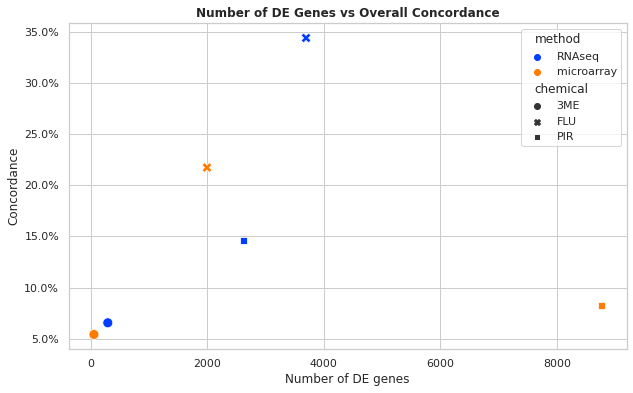

In [31]:
plt.figure(figsize=(10,6))

p1 = sns.scatterplot(data=ocdf, x="Number of DE genes", y="Concordance", hue="method", style="chemical", s=100, palette="bright")
plt.title("Number of DE Genes vs Overall Concordance", fontweight ="bold")
p1.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('Number of DE Genes vs Overall Concordance.png')

In [12]:
# Subdivide the DE genes into “above-median expression” and “below-median expression” groups

# RNA-seq
deseq_MCT_above = deseq_MCT[deseq_MCT['baseMean'] >= deseq_MCT['baseMean'].median()]
deseq_MCT_below = deseq_MCT[deseq_MCT['baseMean'] < deseq_MCT['baseMean'].median()]

deseq_FCZ_above = deseq_FCZ[deseq_FCZ['baseMean'] >= deseq_FCZ['baseMean'].median()]
deseq_FCZ_below = deseq_FCZ[deseq_FCZ['baseMean'] < deseq_FCZ['baseMean'].median()]

deseq_PA_above = deseq_PA[deseq_PA['baseMean'] >= deseq_PA['baseMean'].median()]
deseq_PA_below = deseq_PA[deseq_PA['baseMean'] < deseq_PA['baseMean'].median()]

# microarray
limma_MCT_above = limma_MCT[limma_MCT['AveExpr'] >= limma_MCT['AveExpr'].median()]
limma_MCT_below = limma_MCT[limma_MCT['AveExpr'] < limma_MCT['AveExpr'].median()]
limma_FCZ_above = limma_FCZ[limma_FCZ['AveExpr'] >= limma_FCZ['AveExpr'].median()]
limma_FCZ_below = limma_FCZ[limma_FCZ['AveExpr'] < limma_FCZ['AveExpr'].median()]
limma_PA_above = limma_PA[limma_PA['AveExpr'] >= limma_PA['AveExpr'].median()]
limma_PA_below = limma_PA[limma_PA['AveExpr'] < limma_PA['AveExpr'].median()]

In [13]:
# concordance for split data
# switching names to match abbreviations in paper!! 3ME = MCT, FLU = FCZ, PIR = PA
limma_MCT_above[:5]

,ProbeID,FC,AveExpr,converted_refID
0,1387243_at,1.578477,13.355272,NM_012541
1,1370613_s_at,0.784688,12.775940,NM_012683
2,1387759_s_at,0.992617,11.886910,NM_012683
4,1387901_at,-0.466831,8.513232,NM_019140
5,1372297_at,0.420597,11.195000,NM_001106840


In [14]:
# above and below median concordance 

# deseq above median
AC_3ME_deseq = concordance(deseq_MCT_above, limma_MCT_above, N=N_deseq, idtype='refseqID')
AC_FLU_deseq = concordance(deseq_FCZ_above, limma_FCZ_above, N=N_deseq, idtype='refseqID')
AC_PIR_deseq = concordance(deseq_PA_above, limma_PA_above, N=N_deseq, idtype='refseqID')

# deseq below median
BC_3ME_deseq = concordance(deseq_MCT_below, limma_MCT_below, N=N_deseq, idtype='refseqID')
BC_FLU_deseq = concordance(deseq_FCZ_below, limma_FCZ_below, N=N_deseq, idtype='refseqID')
BC_PIR_deseq = concordance(deseq_PA_below, limma_PA_below, N=N_deseq, idtype='refseqID')
print(AC_3ME_deseq, AC_FLU_deseq, AC_PIR_deseq)

# limma above median 
AC_3ME_limma = concordance(deseq_MCT_above, limma_MCT_above, N=N_limma, idtype='probeID')
AC_FLU_limma = concordance(deseq_FCZ_above, limma_FCZ_above, N=N_limma, idtype='probeID')
AC_PIR_limma = concordance(deseq_PA_above, limma_PA_above, N=N_limma, idtype='probeID')

# limma below median 
BC_3ME_limma = concordance(deseq_MCT_below, limma_MCT_below, N=N_limma, idtype='probeID')
BC_FLU_limma = concordance(deseq_FCZ_below, limma_FCZ_below, N=N_limma, idtype='probeID')
BC_PIR_limma = concordance(deseq_PA_below, limma_PA_below, N=N_limma, idtype='probeID')
print(AC_3ME_limma, AC_FLU_limma, AC_PIR_limma)

0.07800585057058615 0.34877333518407583 0.3843525910372237
0.06664584292379444 0.23261053755482508 0.2700265516589657


In [23]:
# create dataframe for plotting above, below and overall concordance 

# list of concordance numbers 
concordList = [AC_3ME_deseq, AC_FLU_deseq, AC_PIR_deseq, BC_3ME_deseq, BC_FLU_deseq, BC_PIR_deseq, OC_3ME_deseq, OC_FLU_deseq, OC_PIR_deseq, AC_3ME_limma, AC_FLU_limma, AC_PIR_limma, BC_3ME_limma, BC_FLU_limma, BC_PIR_limma, OC_3ME_limma, OC_FLU_limma, OC_PIR_limma]

# convert floating points to percentages
for i in range(len(concordList)):
    concordList[i] = concordList[i]*100
    
print(len(concordList)/3)
chemicals = ['3ME', 'FLU', 'PIR']*6
subsets = (['above']*3 + ['below']*3 + ['overall']*3)*2
methods = ['RNA-Seq']*9 + ['microarray']*9
print(chemicals)
print(subsets)
plotdf = pd.DataFrame(list(zip(concordList, chemicals, subsets, methods)),
              columns=['concordance','chemical', 'subset', 'method'])
print(plotdf)


6.0
['3ME', 'FLU', 'PIR', '3ME', 'FLU', 'PIR', '3ME', 'FLU', 'PIR', '3ME', 'FLU', 'PIR', '3ME', 'FLU', 'PIR', '3ME', 'FLU', 'PIR']
['above', 'above', 'above', 'below', 'below', 'below', 'overall', 'overall', 'overall', 'above', 'above', 'above', 'below', 'below', 'below', 'overall', 'overall', 'overall']
    concordance chemical   subset      method
0      7.800585      3ME    above     RNA-Seq
1     34.877334      FLU    above     RNA-Seq
2     38.435259      PIR    above     RNA-Seq
3      0.985260      3ME    below     RNA-Seq
4     18.305042      FLU    below     RNA-Seq
5     20.639509      PIR    below     RNA-Seq
6      6.548860      3ME  overall     RNA-Seq
7     34.415628      FLU  overall     RNA-Seq
8     14.600461      PIR  overall     RNA-Seq
9      6.664584      3ME    above  microarray
10    23.261054      FLU    above  microarray
11    27.002655      PIR    above  microarray
12     0.984895      3ME    below  microarray
13    11.160501      FLU    below  microarray
14  

<Figure size 432x288 with 0 Axes>

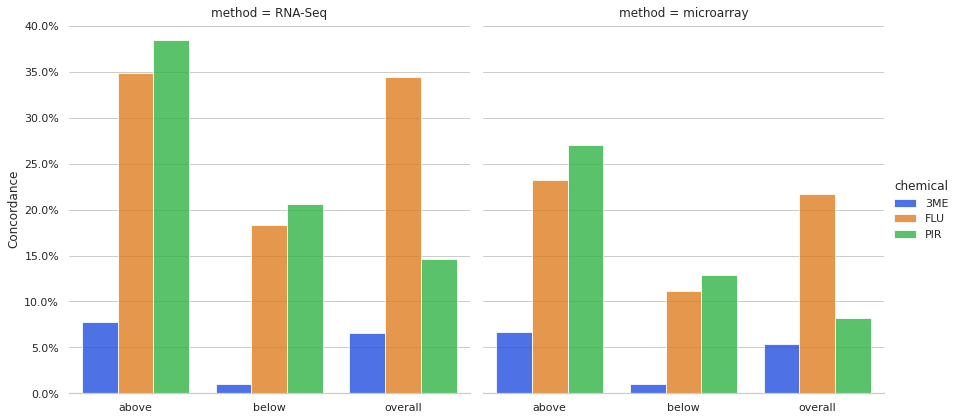

In [26]:
# plotting
plt.figure()
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=plotdf, kind="bar",
    x="subset", y="concordance", hue="chemical", ci=None, palette="bright", alpha=0.8, height=6, col="method")
g.despine(left=True)
g.set_axis_labels("", "Concordance")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter()) # format ticks to display % 
plt.savefig("grouped.png")

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/share/pkg.7/python3/3.7.9/install/bin/python3.7
3.7.9 (default, Oct 26 2020, 11:27:26) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]
sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)


In [35]:
limma_MCT

,ProbeID,FC,AveExpr,converted_refID
0,1387243_at,1.578477,13.355272,NM_012541
1,1370613_s_at,0.784688,12.775940,NM_012683
2,1387759_s_at,0.992617,11.886910,NM_012683
3,1383325_at,0.473877,5.990999,NM_001135576
4,1387901_at,-0.466831,8.513232,NM_019140
5,1372297_at,0.420597,11.195000,NM_001106840
6,1384544_at,0.345375,11.854305,NM_001004086
7,1368168_at,-1.235898,8.568602,NM_053380
8,1380888_at,0.538434,5.982900,NaN
9,1367669_a_at,0.381983,9.681007,NM_022867
